<a href="https://colab.research.google.com/github/mickeykim70/keras_study/blob/main/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download data

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-01-21 13:40:18--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-01-21 13:40:19--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-01-21 13:40:19--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

# 2. Prepare paths of input images and target segmentation masks

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of samples: ", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples:  7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


# 3. What does one input image and corresponding segmentation mask look like?

In [3]:
from IPython.display import Image, display
from keras.utils import load_img
import PIL
from PIL import ImageOps

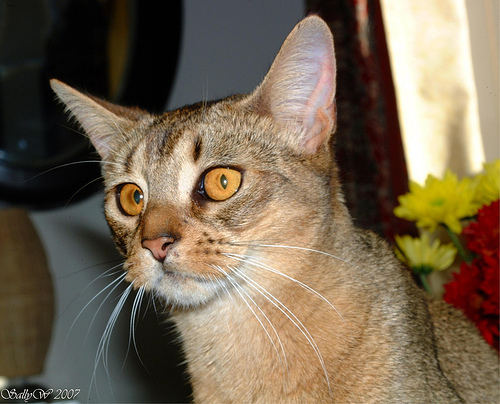

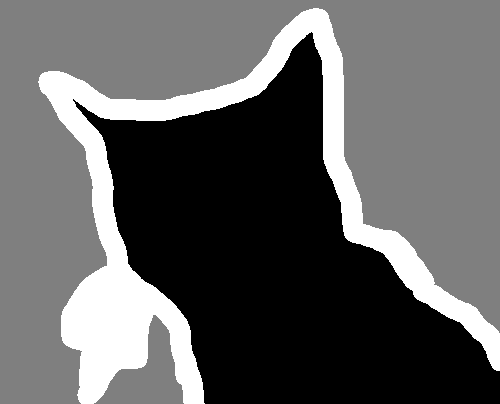

In [4]:
# display input image #10
display(Image(filename=input_img_paths[10]))

# display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[10]))
display(img)

# 4. Prepare Sequence class to load & vectorize batches of data

In [21]:
import keras
import numpy as np
from keras.utils import load_img

class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, **kwargs):
        super().__init__(**kwargs)  # Initialize parents class
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input,output) correspond to batch #idx. """
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i+self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")  # (32, 160, 160, 3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")  # (32, 160, 160, 1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1

        return x, y

# 5. Prepare U-NET Xception-style model

In [22]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))   # (160, 160, 3)

    ### [First half of the network: downsampling inputs] ###

    # 1. Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)   # (80, 80, 32)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) # (80, 80, 32)

    previous_block_activation = x  # Set aside residual


    # 2. Encoder
    # Blocks 1, 2, 3 are identical  apart from the feature depth.

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])    # Add back residual
        previous_block_activation = x    # Set aside next residual

    # 3. Decoder + Pixel Classification
    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# 6. Set aside a validation split

In [25]:
import random

# Split out img paths into a training and validation set
val_samples = 1000
batch_size = 16
img_size = (160, 160)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

# 7. Train the model

In [26]:
# Configure the model for training
# We use "sparse" version of categorical_crossentropy
# because our target data is integers.

model = get_model(img_size=img_size, num_classes=3)

optimizer = keras.optimizers.RMSprop(learning_rate=1e-03)
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "oxford_segmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.6765 - loss: 1.3722 - val_accuracy: 0.5803 - val_loss: 2.1917
Epoch 2/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 63s 95ms/step - accuracy: 0.8142 - loss: 0.4698 - val_accuracy: 0.8137 - val_loss: 0.4658
Epoch 3/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.8420 - loss: 0.4012 - val_accuracy: 0.8401 - val_loss: 0.4057
Epoch 4/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.8584 - loss: 0.3623 - val_accuracy: 0.8458 - val_loss: 0.3943
Epoch 5/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.8712 - loss: 0.3269 - val_accuracy: 0.8388 - val_loss: 0.4374
Epoch 6/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - accuracy: 0.8787 - loss: 0.3060 - val_accuracy: 0.8554 - val_loss: 0.3687
Epoch 7/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 75s 90ms/step - accuracy: 0.8899 - loss: 0.2778 - val_accuracy: 0.8581 - val_loss: 0.3697
Epoch 8/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.8973 - loss: 0.2581 -

# 8. Visualize predictions

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step


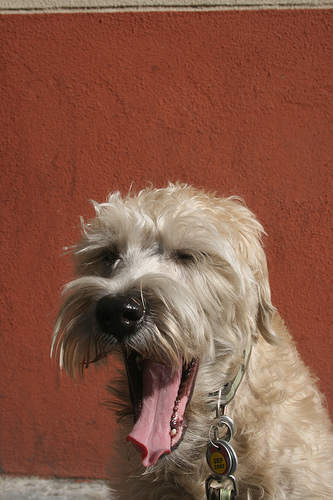

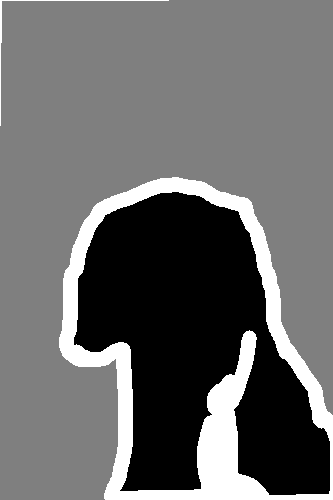

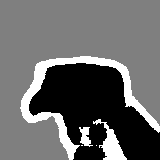

In [28]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)



def display_mask(i):
    """Quick utility to display a model's prediction. """
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image  #10
i = 11

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)   # Note that the model only sees inputs at 150 X 150
